<a href="https://colab.research.google.com/github/deepakri201/SEG_and_SR_for_NLSTSeg/blob/main/technical_validation_volume/technical_validation_volume.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technical validation of volume

Compare the volume from pyradiomics SRs to the volumes reported from the Excel spreadsheets.

Deepa Krishnaswamy

Brigham and Women's Hospital

October 2025

In [ ]:
# output_seg_bucket = "gs://seg_nlst"
input_bucket = "gs://nlstseg" # holds the actual tables and raw data
output_bucket = "gs://nlstseg_seg_and_sr" # holds the output SEG and SR

In [ ]:
!pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git

  Cloning https://github.com/AIM-Harvard/pyradiomics.git to /tmp/pip-req-build-7knt29vm
  Running command git clone --filter=blob:none --quiet https://github.com/AIM-Harvard/pyradiomics.git /tmp/pip-req-build-7knt29vm
  Resolved https://github.com/AIM-Harvard/pyradiomics.git to commit 8ed579383b44806651c463d5e691f3b2b57522ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 147.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 198.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 81.2 MB/s eta 0:00:00
  Created wheel for pyradiomics: filename=pyradiomics-3.1.1.dev111+g8ed579383-cp312-cp312-linux_x86_64.whl size=121811 sha256=24e834edf84d71b484399edf0bd981d88e99dfd209b9920ae9f7a079cd64ecbf
  Stored in directory

# Parameterization

In [ ]:
#@title Enter your Project ID here
# initialize this variable with your Google Cloud Project ID!
project_name = "idc-external-018" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = project_name

!gcloud config set project $project_name

from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


# Environment setup

In [ ]:
!pip install idc-index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 1.3.2
    Uninstalling duckdb-1.3.2:
      Successfully uninstalled duckdb-1.3.2


In [ ]:
from idc_index import IDCClient

idc_client = IDCClient.client()

In [ ]:
import os
import sys
import time

import numpy as np
import pandas as pd
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

import json
from pathlib import Path

from google.cloud import bigquery
from google.cloud import storage

import ast

In [ ]:
# DCMQI - to convert nifti to DICOM Segmentation object
!wget https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
!tar zxvf dcmqi-1.4.0-linux.tar.gz
!cp dcmqi-1.4.0-linux/bin/* /usr/local/bin/

--2025-10-02 19:44:47--  https://github.com/QIICR/dcmqi/releases/download/v1.4.0/dcmqi-1.4.0-linux.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/50675718/915cb14a-48f5-4288-9a5f-bfbcc67daf43?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-02T20%3A32%3A32Z&rscd=attachment%3B+filename%3Ddcmqi-1.4.0-linux.tar.gz&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-02T19%3A32%3A18Z&ske=2025-10-02T20%3A32%3A32Z&sks=b&skv=2018-11-09&sig=phqWM2vdfY6SvUA%2FOCTKRjlRtunBDiot%2BmWL97ez0Ls%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1OTQzNjA4NywibmJmIjoxNzU5NDM0Mjg3LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom
from pydicom.sr.codedict import codes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.0 MB/s eta 0:00:00


In [ ]:
import pydicom

In [ ]:
import shutil

In [ ]:
import copy

In [ ]:
!pip install zenodo-get

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 16.0 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7e5c1b6e3cca0aebae6bd2d5153b4d6e6d2951555b25150f7ac3286745ec0c67
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [ ]:
# !wget https://github.com/rordenlab/dcm2niix/releases/latest/download/dcm2niix_lnx.zip
# !unzip dcm2niix_lnx.zip
# !cp /content/dcm2niix /usr/local/bin

!wget "https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip" \
&& unzip "dcm2niix_lnx.zip" \
&& rm "dcm2niix_lnx.zip" \
&& mv dcm2niix /usr/local/bin/dcm2niix

--2025-10-02 19:45:27--  https://github.com/rordenlab/dcm2niix/releases/download/v1.0.20230411/dcm2niix_lnx.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/25434012/c74be71a-a73f-4945-a116-f02b58a43adf?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-02T20%3A34%3A46Z&rscd=attachment%3B+filename%3Ddcm2niix_lnx.zip&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-02T19%3A34%3A37Z&ske=2025-10-02T20%3A34%3A46Z&sks=b&skv=2018-11-09&sig=lNUzCKf22aEtDZZ4QwdccpAxbkGGuK9Fg961qfddeLw%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1OTQzNDYyNywibmJmIjoxNzU5NDM0MzI3LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGl

In [ ]:
import subprocess

In [ ]:
# !pip install --no-cache-dir pyradiomics
# !pip install --no-cache-dir git+https://github.com/AIM-Harvard/pyradiomics.git
import radiomics
from radiomics import featureextractor, generalinfo

In [ ]:
import logging

In [ ]:
from functools import partial

In [ ]:
from tqdm import tqdm

In [ ]:
from pydicom import dcmread

In [ ]:
import SimpleITK as sitk

In [ ]:
!pip install highdicom
import highdicom as hd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 28.6 MB/s eta 0:00:00


# Get Excel spreadsheets from NLSTSeg

In [ ]:
# Download tables - also in BQ.

if not os.path.isdir("/content/table"):
  os.mkdir("/content/table")

nlstseg_image_filename = os.path.join(input_bucket, "table", "Image.xlsx")
nlstseg_patient_filename = os.path.join(input_bucket, "table", "Patient.xlsx")
nlstseg_label_filename = os.path.join(input_bucket, "table", "Label.xlsx")

!gsutil cp $nlstseg_image_filename "/content/table/Image.xlsx"
!gsutil cp $nlstseg_patient_filename "/content/table/Patient.xlsx"
!gsutil cp $nlstseg_label_filename "/content/table/Label.xlsx"

Copying gs://nlstseg/table/Image.xlsx...
- [1 files][ 67.3 KiB/ 67.3 KiB]                                                
Operation completed over 1 objects/67.3 KiB.                                     
Copying gs://nlstseg/table/Patient.xlsx...
/ [1 files][ 38.5 KiB/ 38.5 KiB]                                                
Operation completed over 1 objects/38.5 KiB.                                     
Copying gs://nlstseg/table/Label.xlsx...
/ [1 files][ 70.8 KiB/ 70.8 KiB]                                                
Operation completed over 1 objects/70.8 KiB.                                     


In [ ]:
# Read the table into dataframe - to get the corresponding SeriesInstanceUID

df_image = pd.read_excel("/content/table/Image.xlsx")
df_label = pd.read_excel("/content/table/Label.xlsx")
df_patient = pd.read_excel("/content/table/Patient.xlsx")

In [ ]:
df_label.head()

,Mainfolder,ID,Stage,Mark_labels,Tumor_V(cm3),labels_type,SizeX,SizeY,Slice,Slice_thikness,Lung_loc,PixelspcingX,PixelspacingY
0,01_LungTumor,100012,Stage IA,1,5.84,1,512,512,157,2.0,Right upper lobe,-0.546875,-0.546875
1,01_LungTumor,100147,Stage IA,1,4.80,1,512,512,116,2.5,Right upper lobe,-0.644531,-0.644531
2,01_LungTumor,100158,Stage IA,1,1.02,1,512,512,146,2.0,Right upper lobe,-0.683594,-0.683594
3,01_LungTumor,100242,Stage IA,1,0.40,1,512,512,123,2.5,Left upper lobe,-0.566406,-0.566406
4,01_LungTumor,100280,Stage IA,1,1.21,1,512,512,155,2.0,Left lower lobe,-0.550781,-0.550781


In [ ]:
len(list(set(df_label['ID'].values)))

605

In [ ]:
print(len(list(set(df_image['ID'].values))))
print(len(list(set(df_image['StudyInstanceUID'].values))))
print(len(list(set(df_image['SeriesInstanceUID'].values))))

605
602
602


# Compare volumes using BQ table

## BQ table

In [ ]:
client_bq = bigquery.Client(project=project_name)

query = f"""
    SELECT
      PatientID,
      StudyInstanceUID,
      sourceSegmentedSeriesUID,
      segmentationSegmentNumber,
      findingSite.CodeMeaning,
      Value,
      viewer_url
    FROM
      `idc-external-018.nlstseg_seg_and_sr.quantitative_measurements_with_urls`
    WHERE
      Quantity.CodeMeaning = "Volume from Voxel Summation"
    ORDER BY
      PatientID,
      StudyInstanceUID,
      sourceSegmentedSeriesUID,
      segmentationSegmentNumber
      """

df_meas = client_bq.query(query).to_dataframe()

In [ ]:
df_meas.head()

,PatientID,StudyInstanceUID,sourceSegmentedSeriesUID,segmentationSegmentNumber,CodeMeaning,Value,viewer_url
0,100012,1.2.840.113654.2.55.38321092839390108338558865...,1.2.840.113654.2.55.13508825378604927579146345...,1,Adenocarcinoma,5840.881000000,https://viewers-sandbox-gha-testing.web.app/vi...
1,100147,1.2.840.113654.2.55.31958452963320032523273261...,1.2.840.113654.2.55.15708941008648745210499888...,1,Adenocarcinoma,4796.026000000,https://viewers-sandbox-gha-testing.web.app/vi...
2,100158,1.2.840.113654.2.55.81185422866512279860334872...,1.2.840.113654.2.55.31060976780967844152296392...,1,Adenocarcinoma,1022.454000000,https://viewers-sandbox-gha-testing.web.app/vi...
3,100242,1.2.840.113654.2.55.22835224307907880875083018...,1.2.840.113654.2.55.38995485391900019876570761...,1,Lepidic Adenocarcinoma,401.020000000,https://viewers-sandbox-gha-testing.web.app/vi...
4,100280,1.2.840.113654.2.55.30207427775351702734806349...,1.2.840.113654.2.55.11168439182281552750699540...,1,Adenocarcinoma,1211.013000000,https://viewers-sandbox-gha-testing.web.app/vi...


In [ ]:
len(list(set(df_meas['PatientID'].values)))

571

In [ ]:
len(list(set(df_meas['StudyInstanceUID'].values)))

571

In [ ]:
len(list(set(df_meas['sourceSegmentedSeriesUID'].values)))

571

## Now join and compare volume

In [ ]:
df_label['ID'] = [str(f) for f in df_label['ID'].values]
df_join = pd.merge(df_label, df_meas, how='inner', left_on=['ID', 'Mark_labels'], right_on=['PatientID', 'segmentationSegmentNumber'])
df_join['Value_mod'] = [np.float32(f)/1000.00 for f in df_join['Value'].values]
print(len(df_join))
print(len(list(set(df_join['PatientID'].values))))

671
571


avg_diff: 1.920534117384944e-05
min_diff: -0.0050000262260436745
max_diff: 0.004996007084846488
std_diff: 0.0028889231867906167


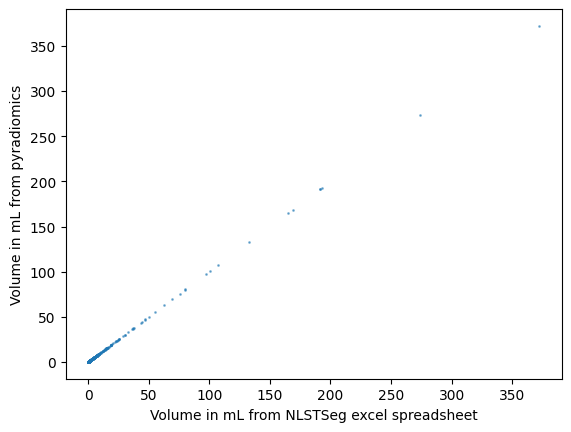

In [ ]:
# Now plot

nlstseg_values = df_join['Tumor_V(cm3)'].values
pyradiomics_values = df_join['Value_mod'].values

diff_values = nlstseg_values - pyradiomics_values
df_join['volume_diff'] = df_join['Tumor_V(cm3)'].values - df_join['Value_mod'].values

avg_diff = np.mean(diff_values)
min_diff = np.min(diff_values)
max_diff = np.max(diff_values)
std_diff = np.std(diff_values)
print('avg_diff: ' + str(avg_diff))
print('min_diff: ' + str(min_diff))
print('max_diff: ' + str(max_diff))
print('std_diff: ' + str(std_diff))

plt.figure()
plt.scatter(nlstseg_values, pyradiomics_values, s=1, alpha=0.5)
plt.xlabel('Volume in mL from NLSTSeg excel spreadsheet')
plt.ylabel('Volume in mL from pyradiomics')
plt.show()

# Compare volume by parsing SRs

## Parse SRs

In [ ]:
def get_finding_sites(container):
    """Extract finding sites from a ContainerContentItem."""
    sites = []
    for item in container.ContentSequence:
        if "ConceptNameCodeSequence" in item:
            cn = item.ConceptNameCodeSequence[0]
            if cn.CodeMeaning == "Finding Site":   # or match CodeValue == "363698007"
                cc = item.ConceptCodeSequence[0]
                sites.append({
                    "CodeValue": cc.CodeValue,
                    "CodingSchemeDesignator": cc.CodingSchemeDesignator,
                    "CodeMeaning": cc.CodeMeaning
                })
    return sites

In [ ]:
# Get all the SRs from the bucket

# from google.cloud import storage

# # https://cloud.google.com/storage/docs/listing-objects#storage-list-objects-python
# def list_blobs(bucket_name):
#   """Lists all the blobs in the bucket."""
#   storage_client = storage.Client()
#   # Note: Client.list_blobs requires at least package version 1.17.0.
#   blobs = storage_client.list_blobs(bucket_name)
#   # Note: The call returns a response only when the iterator is consumed.
#   blob_names = []
#   for blob in blobs:
#     blob_names.append(blob.name)

#   return blob_names

# sr_filenames = list_blobs("nlstseg_seg_and_sr")
# # accidentally put them in the wrong folder.
# # need shape SR
# sr_filenames = [f for f in sr_filenames if f.startswith("sr_first_order")]
# print(len(sr_filenames))

# Copy all from bucket to folder
if not os.path.isdir("/content/sr"):
  os.mkdir("/content/sr")
!gsutil -m cp -r "gs://nlstseg_seg_and_sr/sr_first_order/*" "/content/sr"

# sr_filenames_test = ["sr_first_order/1.2.840.113654.2.55.187857917939828293012159647405356583161_sr.dcm"]

601
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.101995309829064050675770434766964356695_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.10212803674068251180698456742623207615_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.102236556545478157092621557341658509914_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.102595981262437924743384555490348997068_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.102679371468953163285569140890061441420_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.10833386426630411862343500018633576155_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.103164989352592098929741164632137395127_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.2.55.105508597935357050120573060055759818144_sr.dcm...
Copying gs://nlstseg_seg_and_sr/sr_first_order/1.2.840.113654.

In [ ]:
# list all files in folder

sr_filenames = os.listdir("/content/sr")
sr_filenames = [os.path.join("/content/sr",f) for f in sr_filenames]
print(len(sr_filenames))


601


In [ ]:
features_sr_df_all = pd.DataFrame()
num_sites_all = []
num_measurements_all = []

for index, sr_filename in enumerate(sr_filenames,1):

  print('**** index: ' + str(index) + ' *****')

  source_segmentedSeriesInstanceUID = os.path.basename(sr_filename)
  source_segmentedSeriesInstanceUID = source_segmentedSeriesInstanceUID.split('_')[0]
  print('source_segmentedSeriesInstanceUID: ' + str(source_segmentedSeriesInstanceUID))

  sr = hd.sr.srread(sr_filename)
  num_sites = len(sr.content.get_volumetric_roi_measurement_groups())
  print('num_sites: ' + str(num_sites))
  num_sites_all.append(num_sites)

  PatientID = sr.PatientID
  StudyInstanceUID = sr.StudyInstanceUID

  for n in range(0,num_sites):

    mg_container = sr.content.get_volumetric_roi_measurement_groups()[n][0]
    sites = get_finding_sites(mg_container)
    CodeMeaning = sites[0]['CodeMeaning']

    # This particular SR has some volumetric ROI measurement groups, and we can
    # get a list of them with the "get_volumetric_roi_measurement_groups" method.
    # See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.MeasurementReport.get_volumetric_roi_measurement_groups
    # The return value is a list of hd.highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations objects
    # See https://highdicom.readthedocs.io/en/latest/package.html#highdicom.sr.VolumetricROIMeasurementsAndQualitativeEvaluations
    # all_groups = sr.content.get_volumetric_roi_measurement_groups()
    # num_groups = len(all_groups)

    # group = sr.content.get_volumetric_roi_measurement_groups()[0]
    group = sr.content.get_volumetric_roi_measurement_groups()[n]
    ref_seg_sop_id = group.referenced_segment.referenced_sop_instance_uid
    referenced_segment_number = group.referenced_segment[0].ReferencedSOPSequence[0].ReferencedSegmentNumber

    feature_name_values = []
    feature_name_schemes = []
    feature_name_meanings = []
    feature_unit_values = []
    feature_unit_schemes = []
    feature_unit_meanings = []
    values = []
    ref_seg_sop_ids = []

    features_sr_df = pd.DataFrame()

    measurements = group.get_measurements()
    num_measurements = len(measurements)
    num_measurements_all.append(num_measurements) # same as number of total lesions.

    for m in range(0,num_measurements):
      measurement = measurements[m]
      feature_name_values.append(measurement.name.value)
      feature_name_schemes.append(measurement.name.scheme_designator)
      feature_name_meanings.append(measurement.name.meaning)
      feature_unit_values.append(measurement.unit.value)
      feature_unit_schemes.append(measurement.unit.scheme_designator)
      feature_unit_meanings.append(measurement.unit.meaning)
      values.append(measurement.value)
      ref_seg_sop_ids.append(ref_seg_sop_id)

    # Form dataframe
    features_sr_df['PatientID'] = [PatientID] * len(feature_name_values)
    features_sr_df['StudyInstanceUID'] = [StudyInstanceUID] * len(feature_name_values)
    features_sr_df['ReferencedSegmentNumber'] = [referenced_segment_number] * len(feature_name_values)
    features_sr_df['site'] = [CodeMeaning] * len(feature_name_values)
    features_sr_df['feature_name_value'] = feature_name_values
    features_sr_df['feature_name_code'] = feature_name_schemes
    features_sr_df['feature_name_meaning'] = feature_name_meanings
    features_sr_df['feature_unit_value'] = feature_unit_values
    features_sr_df['feature_unit_code'] = feature_unit_schemes
    features_sr_df['features_unit_meaning'] = feature_unit_meanings
    features_sr_df['value'] = values
    features_sr_df['ref_sop_id'] = ref_seg_sop_ids

    # Append to full dataframe
    features_sr_df_all = pd.concat([features_sr_df_all, features_sr_df])


**** index: 1 *****
source_segmentedSeriesInstanceUID: 1.2.840.113654.2.55.45151121745699107989582039628064168858
num_sites: 1
**** index: 2 *****
source_segmentedSeriesInstanceUID: 1.2.840.113654.2.55.204642191063326653170110007925732322027
num_sites: 1
**** index: 3 *****
source_segmentedSeriesInstanceUID: 1.2.840.113654.2.55.196622501102736074294090844425373743728
num_sites: 1
**** index: 4 *****
source_segmentedSeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7009.9004.138475685444403243712417929667
num_sites: 1
**** index: 5 *****
source_segmentedSeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7009.9004.192525281608175837322789780307
num_sites: 1
**** index: 6 *****
source_segmentedSeriesInstanceUID: 1.3.6.1.4.1.14519.5.2.1.7009.9004.758651454056241277004038704552
num_sites: 1
**** index: 7 *****
source_segmentedSeriesInstanceUID: 1.2.840.113654.2.55.252790578163294500394363956440600203102
num_sites: 1
**** index: 8 *****
source_segmentedSeriesInstanceUID: 1.2.840.113654.2.55.137284376304168

In [ ]:
np.unique(num_sites_all)

array([1, 2, 3, 4, 5, 7])

## Compare volume

In [ ]:
features_sr_df_all.columns

Index(['PatientID', 'StudyInstanceUID', 'ReferencedSegmentNumber', 'site',
       'feature_name_value', 'feature_name_code', 'feature_name_meaning',
       'feature_unit_value', 'feature_unit_code', 'features_unit_meaning',
       'value', 'ref_sop_id'],
      dtype='object')

In [ ]:
print(len(list(set(features_sr_df_all['PatientID'].values))))

571


In [ ]:
volume_features_sr_df = features_sr_df_all[features_sr_df_all['feature_name_meaning']=="Volume from Voxel Summation"]
print(len(volume_features_sr_df))
print(len(list(set(volume_features_sr_df['PatientID'].values)))) # why still only 571 patients?! I downloaded 601 SRs.

671
571


In [ ]:
len(list(set(df_label['ID'].values)))

605

In [ ]:
len(df_label)

715

In [ ]:
# Now join to excel
df_label['ID'] = [str(f) for f in df_label['ID'].values]
df_join = pd.merge(df_label, volume_features_sr_df, how='inner', left_on=['ID', 'Mark_labels'], right_on=['PatientID', 'ReferencedSegmentNumber'])
df_join['Value_mod'] = [np.float32(f)/1000.00 for f in df_join['value'].values]
print(len(df_join))
print(len(list(set(df_join['PatientID'].values))))

671
571


In [ ]:
# find which patients are in df_label and are not in volume_features_sr_df
patients1 = sorted(list(set(df_label['ID'].values)))
patients2 = sorted(list(set(volume_features_sr_df['PatientID'].values)))
patients_missing = sorted(list(set(patients1) - set(patients2)))
print(len(patients_missing))
# weird.. i know 4 are wrong - i manually discarded. so 30. same exact number missing from dicom_all..... but why.

patients_missing[0]

34


'103359'

avg_diff: 1.920534117384944e-05
min_diff: -0.0050000262260436745
max_diff: 0.004996007084846488
std_diff: 0.0028889231867906167


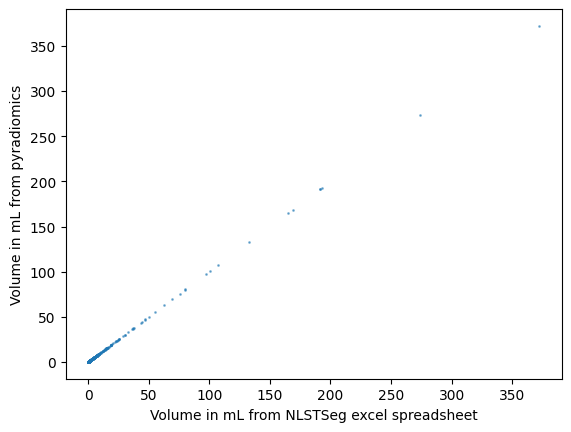

In [ ]:
# Now plot

nlstseg_values = df_join['Tumor_V(cm3)'].values
pyradiomics_values = df_join['Value_mod'].values

diff_values = nlstseg_values - pyradiomics_values
df_join['volume_diff'] = df_join['Tumor_V(cm3)'].values - df_join['Value_mod'].values

avg_diff = np.mean(diff_values)
min_diff = np.min(diff_values)
max_diff = np.max(diff_values)
std_diff = np.std(diff_values)
print('avg_diff: ' + str(avg_diff))
print('min_diff: ' + str(min_diff))
print('max_diff: ' + str(max_diff))
print('std_diff: ' + str(std_diff))

plt.figure()
plt.scatter(nlstseg_values, pyradiomics_values, s=1, alpha=0.5)
plt.xlabel('Volume in mL from NLSTSeg excel spreadsheet')
plt.ylabel('Volume in mL from pyradiomics')
plt.show()